In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import h5py
import pandas as pd
import os.path as osp
import json
from scipy.io import loadmat
import mne
import seaborn as sns

In [14]:
# mat = scipy.io.loadmat("../data/derivatives/RDM/stats_RDM_full.mat")
DATA_PATH = "../data"

## Loading Data

Loading participant data

In [15]:
participants_data = pd.read_csv(osp.join(DATA_PATH, "participants.tsv"), sep="\t")
participants_data.head()
print(participants_data.shape)

(50, 8)


Understanding what each header means

In [16]:
with open(osp.join(DATA_PATH, "participants.json"), "rb") as f:
    participants_data_meta = json.load(f)
participants_data_meta

{'participant_id': {'Description': 'participant number'},
 'age': {'Description': 'participant age in years at time of acquisition'},
 'gender': {'Description': 'participant self-reported gender (M:Male, F:Female)'},
 'native_english': {'Description': 'Whether the participant was a native English speaker'},
 'language_profile': {'Description': 'Number of languages spoken'},
 'language_spoken_at_home': {'Description': 'Language spoken at home'},
 'exclude': {'Description': '1 for suggested exclusion of participant due to very poor signal or missing data'},
 'note_IZ': {'Description': 'Experimenter notes'}}

Loading a single participants EEG data using the mne package

In [17]:
bv = mne.io.read_raw_brainvision("../data/sub-01/eeg/sub-01_task-rsvp_eeg.vhdr")
bv

Extracting parameters from ../data/sub-01/eeg/sub-01_task-rsvp_eeg.vhdr...
Setting channel info structure...


<RawBrainVision | sub-01_task-rsvp_eeg.eeg, 63 x 3035740 (3035.7 s), ~93 kB, data not loaded>

In [18]:
# extract some useful values
times = bv.times # time values of each sample
N = bv.n_times # sample count
channel_types = bv.get_channel_types()

In [19]:
data = bv.get_data()
data.shape

(63, 3035740)

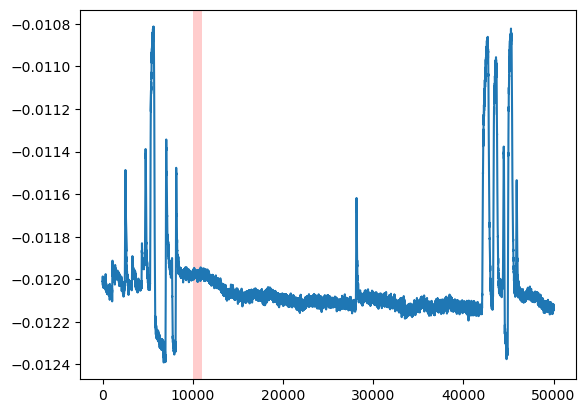

In [29]:
ax = plt.plot(data[0][:50000])
# Zoom in
plt.axvspan(10000, 11000, facecolor='red', alpha=.2)

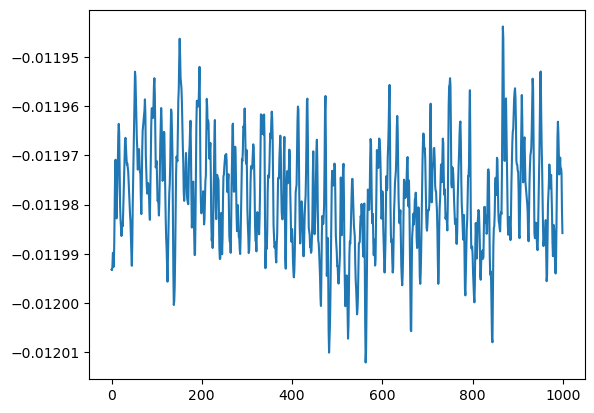

In [30]:
plt.plot(data[0][10000:11000])

In [31]:
welch_psd = bv.compute_psd()
welch_psd.shape

Effective window size : 0.256 (s)


(63, 129)

EDA for subject 1
--

In [33]:
df1 = pd.read_csv(osp.join(DATA_PATH, "sub-01/eeg/sub-01_task-rsvp_events.csv"))
df1.head()

,eventnumber,objectnumber,object,sequencenumber,presentationnumber,blocksequencenumber,withinsequencenumber,stimnumber,stim,istarget,stimname,response,rt,correct,time_stimon,time_stimoff,stimdur
0,0,275,carousel,0,0,0,0,10,stimuli\carousel\carousel_11s.jpg,0,carousel_11s.jpg,0.0,0.0,0.0,61.552560,61.602540,0.049980
1,1,1165,piano,0,1,0,0,4,stimuli\piano\piano_05n.jpg,0,piano_05n.jpg,0.0,0.0,0.0,61.652560,61.702538,0.049977
2,2,1735,turntable,0,2,0,0,11,stimuli\turntable\turntable_12s.jpg,0,turntable_12s.jpg,0.0,0.0,0.0,61.752561,61.802545,0.049984
3,3,1643,tent,0,3,0,0,7,stimuli\tent\tent_08n.jpg,0,tent_08n.jpg,0.0,0.0,0.0,61.852564,61.902516,0.049951
4,4,1564,stove2,0,4,0,0,8,stimuli\stove2\stove2_09s.jpg,0,stove2_09s.jpg,0.0,0.0,0.0,61.952542,62.002516,0.049974


In [34]:
df1[['time_stimoff', 'time_stimon', 'stimdur']].describe()

,time_stimoff,time_stimon,stimdur
count,22248.000000,22248.000000,22248.000000
mean,1553.889417,1553.839433,0.049984
std,897.850962,897.850966,0.000276
min,61.602540,61.552560,0.047609
25%,756.204358,756.154372,0.049976
50%,1520.591367,1520.541387,0.049980
75%,2357.138630,2357.088649,0.049985
max,3074.016016,3073.966039,0.083347


In [50]:
# Preprocess the object names, remove numbers at the end of the string

df1.object = df1.object.map(lambda x: x.rstrip("0123456789"))
df1.head()

,eventnumber,objectnumber,object,sequencenumber,presentationnumber,blocksequencenumber,withinsequencenumber,stimnumber,stim,istarget,stimname,response,rt,correct,time_stimon,time_stimoff,stimdur
0,0,275,carousel,0,0,0,0,10,stimuli\carousel\carousel_11s.jpg,0,carousel,0.0,0.0,0.0,61.552560,61.602540,0.049980
1,1,1165,piano,0,1,0,0,4,stimuli\piano\piano_05n.jpg,0,piano,0.0,0.0,0.0,61.652560,61.702538,0.049977
2,2,1735,turntable,0,2,0,0,11,stimuli\turntable\turntable_12s.jpg,0,turntable,0.0,0.0,0.0,61.752561,61.802545,0.049984
3,3,1643,tent,0,3,0,0,7,stimuli\tent\tent_08n.jpg,0,tent,0.0,0.0,0.0,61.852564,61.902516,0.049951
4,4,1564,stove,0,4,0,0,8,stimuli\stove2\stove2_09s.jpg,0,stove,0.0,0.0,0.0,61.952542,62.002516,0.049974


Analysis
--

Here is a variable you want to assign for the results: `eeg_spike_results`. It is an array of arrays with the count of the EEG spikes.

Right now I only put 3 entries of 3 features, as an example.

[[150 150 150]
 [140 155 155]
 [155 155 140]]
            Sum of power of spike threshold
artificial                       148.333333
natural                          153.333333
food                             148.333333


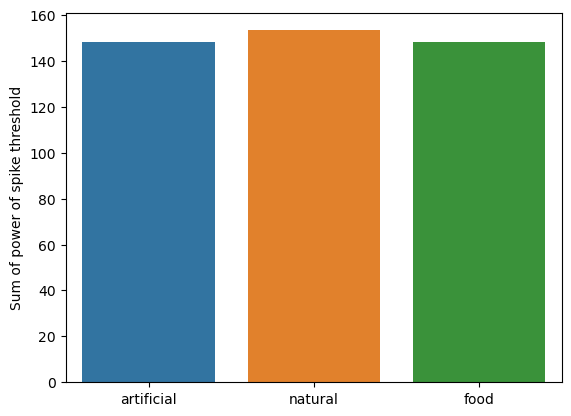

In [11]:
eeg_categories = ["artificial", "natural", "food"]
eeg_spike_results = np.array([[150, 150, 150], [140, 155, 155], [155, 155, 140]])
eeg_spike_avg = []

print(eeg_spike_results)

# take the average of each column
for i in range(len(eeg_spike_results)):
    eeg_spike_avg.append(np.mean(eeg_spike_results[:, i]))

eeg_df = pd.DataFrame(data = np.array(eeg_spike_avg).transpose(), index = eeg_categories, columns = ["Sum of power of spike threshold"])
print(eeg_df)

plot_results = sns.barplot(x = eeg_df.index, y = eeg_df["Sum of power of spike threshold"])

Analysis:

We will use the 1 way ANOVA test to see if there is a significant difference between subjects so we know that it isn't just preference what makes people happy.

Null Hypothesis: There is a significant difference between the means of the participants' scores that people have their given category invoke happy feelings.

Alternative Hypothesis: There is no significant difference between the means of the participants' scores that people have their given category invoke happy feelings.

In [9]:
from scipy.stats import f_oneway

# 1 way ANOVA test
print(f_oneway(*eeg_spike_results.transpose().tolist()))

F_onewayResult(statistic=0.6000000000000001, pvalue=0.5787037037037035)


Because the p-value is ________ than the alpha value of 0.05, we can...